In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\fhacesga\AppData\Local\Temp\ipykernel_32248\1811205482.py:17: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. 

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


IO directories depending on which machine. 

In [3]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

For each image we are processing, identify street corners

In [4]:
proc_dir = r"D:\CaseStudies\CornerDigitization\\"
tiles_cor = glob.glob(proc_dir + "images/*.tif")

out = processTiledYOLOs(tiles_cor, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])

cornercoords_dict_corners = out[0]
streetcorner_dict_corners = out[1]

proc_dir = r"D:\CaseStudies\Registration\\"
tiles_reg = glob.glob(proc_dir + "images/*.tif")

out = processTiledYOLOs(tiles_reg, tiled_yolo_model_paths, ['CornerCoordinates', 'street_corners'], proc_dir, imsizes=[256, 320])

cornercoords_dict_reg = out[0]
streetcorner_dict_reg = out[1]

Making images half size for tiled inference


  0%|          | 0/14 [00:00<?, ?it/s]

Reading from D:\CaseStudies\CornerDigitization\\CornerCoordinates.pkl
Reading from D:\CaseStudies\CornerDigitization\\street_corners.pkl
Making images half size for tiled inference


  0%|          | 0/31 [00:00<?, ?it/s]

Reading from D:\CaseStudies\Registration\\CornerCoordinates.pkl
Reading from D:\CaseStudies\Registration\\street_corners.pkl


In [5]:
corner_dir = r"D:\CaseStudies\joint_pkls\\"
vector_out = r"D:\CaseStudies\out_vectors\\"

def getBBOX(im_file, RLNN):
    bounds, RLNN = findBounds(im_file, RLNN)

    image = np.asarray(cv2.imread(im_file))
    # IF BOUNDS FOUND, USE. ELSE, USE IMAGE BOUNDS
    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {im_file}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
    return bbox, RLNN

def getTileCorners(tile_dir, ra_ref, conf_thresh=0.05, filter_by_bounding_box=True):

    tile_name = os.path.basename(tile_dir).split(".")[0]

    with open(f"{corner_dir}/{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > conf_thresh]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        corner_confs = np.array([a.score.value for a in x if a.score.value > conf_thresh])
        print(f"{len(corner_bbox)} / {len(x)}")

    if len(corner_bbox) == 0:
        return None, None

    corner_arry  = np.int32(corner_arry)
    corner_confs = np.float32(corner_confs)

    if filter_by_bounding_box:
        bbox, _ = getBBOX(tile_dir, None)
        corner_arry, corner_confs = cleanCenterBBOX(corner_arry, bbox, opt_return=[corner_confs])

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])
    return im_corner_gdf, corner_confs

for tile in tqdm(tiles_reg + tiles_cor):
    ra_ref = rio.open(tile)
    out_path = os.path.join(vector_out, os.path.basename(tile).split(".")[0] + ".shp")
    if os.path.exists(out_path):
        continue
    a, b = getTileCorners(tile, ra_ref, conf_thresh=0.05)
    a['confidence'] = b
    a = a.set_crs("EPSG:3857")
    a.to_file(out_path)

  0%|          | 0/45 [00:00<?, ?it/s]

In [6]:
corners     = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")

In [7]:
out_lines = r"D:\CaseStudies\out_connections\\"

def connect_to_nearest(gdf_a, gdf_b, output_path):
    # Ensure same CRS
    if gdf_a.crs != gdf_b.crs:
        gdf_b = gdf_b.to_crs(gdf_a.crs)

    # Extract coordinates
    coords_a = np.array([(geom.x, geom.y) for geom in gdf_a.geometry], dtype=float)
    coords_b = np.array([(geom.x, geom.y) for geom in gdf_b.geometry], dtype=float)

    # Build KDTree for efficient nearest-neighbor search
    tree = cKDTree(coords_b)
    distances, indices = tree.query(coords_a)

    # Create LineStrings from A to closest B
    lines = [
        LineString([gdf_a.geometry.iloc[i], gdf_b.geometry.iloc[indices[i]]])
        for i in range(len(gdf_a))
    ]

    # Create GeoDataFrame and export
    gdf_lines = gpd.GeoDataFrame(geometry=lines, crs=gdf_a.crs)
    gdf_lines.to_file(output_path)

# Example usage
# gdf_a = gpd.read_file("points_a.gpkg")
# gdf_b = gpd.read_file("points_b.gpkg")
# connect_to_nearest(gdf_a, gdf_b, "output_lines.gpkg")
for tile in tqdm(glob.glob(vector_out + "*.shp")):
    gdf_a = gpd.read_file(tile)
    if os.path.exists(os.path.join(out_lines, os.path.basename(tile))):
        continue
    connect_to_nearest(gdf_a, corners, os.path.join(out_lines, os.path.basename(tile)))
    pass

  0%|          | 0/46 [00:00<?, ?it/s]

In [8]:
manual_validation = r"D:\CaseStudies\Manual\\"

manual_gdfs = []
for a in glob.glob(manual_validation+"*.shp"):
    other_fn = os.path.join(vector_out, os.path.basename(a))

    manual_gdf = gpd.read_file(a)
    line_gdf = gpd.read_file(other_fn)

    print(manual_gdf.keys(), manual_gdf.shape)
    print(line_gdf.keys(), line_gdf.shape)

    line_gdf = line_gdf.rename(columns={'geometry': 'geometry_2'})
    manual_gdf_a = pd.concat([manual_gdf, line_gdf], axis=1)

    manual_gdf_a['length'] = manual_gdf_a.geometry.length
    manual_gdf_a['name'] = os.path.basename(a)

    if "48201" in os.path.basename(a):
        manual_gdf_a['method'] = "CornerCoordinate"
    else:
        manual_gdf_a['method'] = "Registration"


    manual_gdfs.append(gpd.GeoDataFrame(manual_gdf_a))

Index(['FID', 'MATCH', 'geometry'], dtype='object') (903, 3)
Index(['confidence', 'geometry'], dtype='object') (903, 2)
Index(['FID', 'MATCH', 'geometry'], dtype='object') (635, 3)
Index(['confidence', 'geometry'], dtype='object') (635, 2)
Index(['FID', 'MATCH', 'geometry'], dtype='object') (1584, 3)
Index(['confidence', 'geometry'], dtype='object') (1584, 2)
Index(['FID', 'MATCH', 'geometry'], dtype='object') (1352, 3)
Index(['confidence', 'geometry'], dtype='object') (1352, 2)


(903, 8)
(635, 8)
(1584, 8)
(1352, 8)


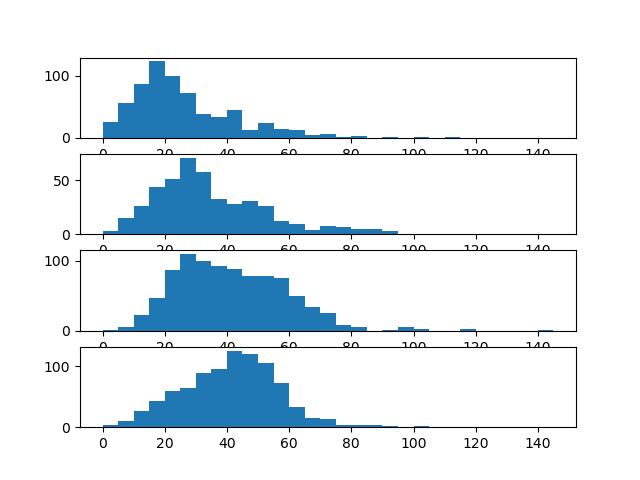

In [9]:
fig, axs = plt.subplots(len(manual_gdfs))

for i, ax in enumerate(axs):
    print(manual_gdfs[i].shape)
    
    ax.hist(manual_gdfs[i][manual_gdfs[i]['MATCH'] == 1]['length'], bins=range(0, 150, 5))
    # ax.hist(manual_gdfs[i][manual_gdfs[i]['MATCH'] == 0]['length'], bins=range(0, 200, 5))

In [10]:
import seaborn as sns

In [11]:
test = pd.concat(manual_gdfs)

Text(0, 0.5, 'Frequency (count)')

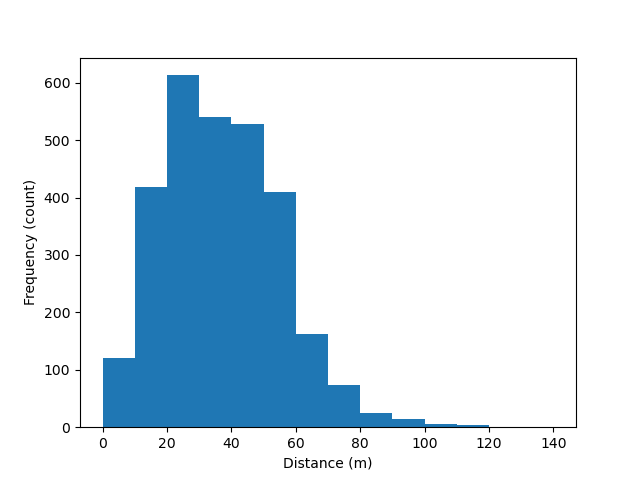

In [12]:
fig, axs = plt.subplots()

axs.hist(test[test['MATCH'] == 1]['length'], bins=range(0, 150, 10))

axs.set_xlabel("Distance (m)")
axs.set_ylabel("Frequency (count)")

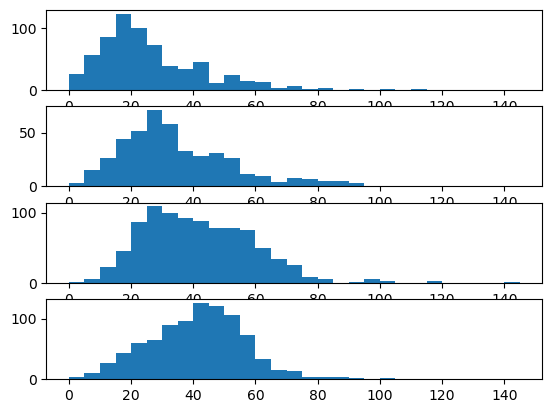

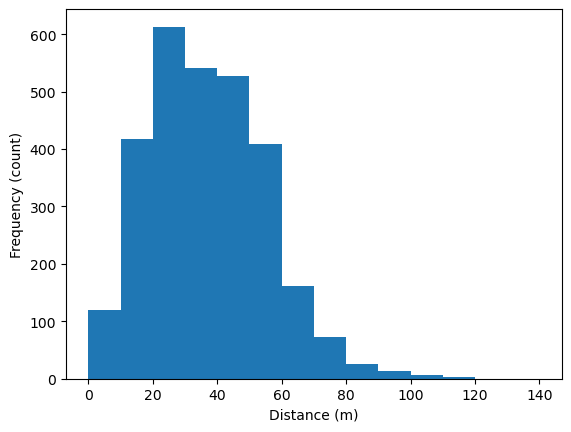

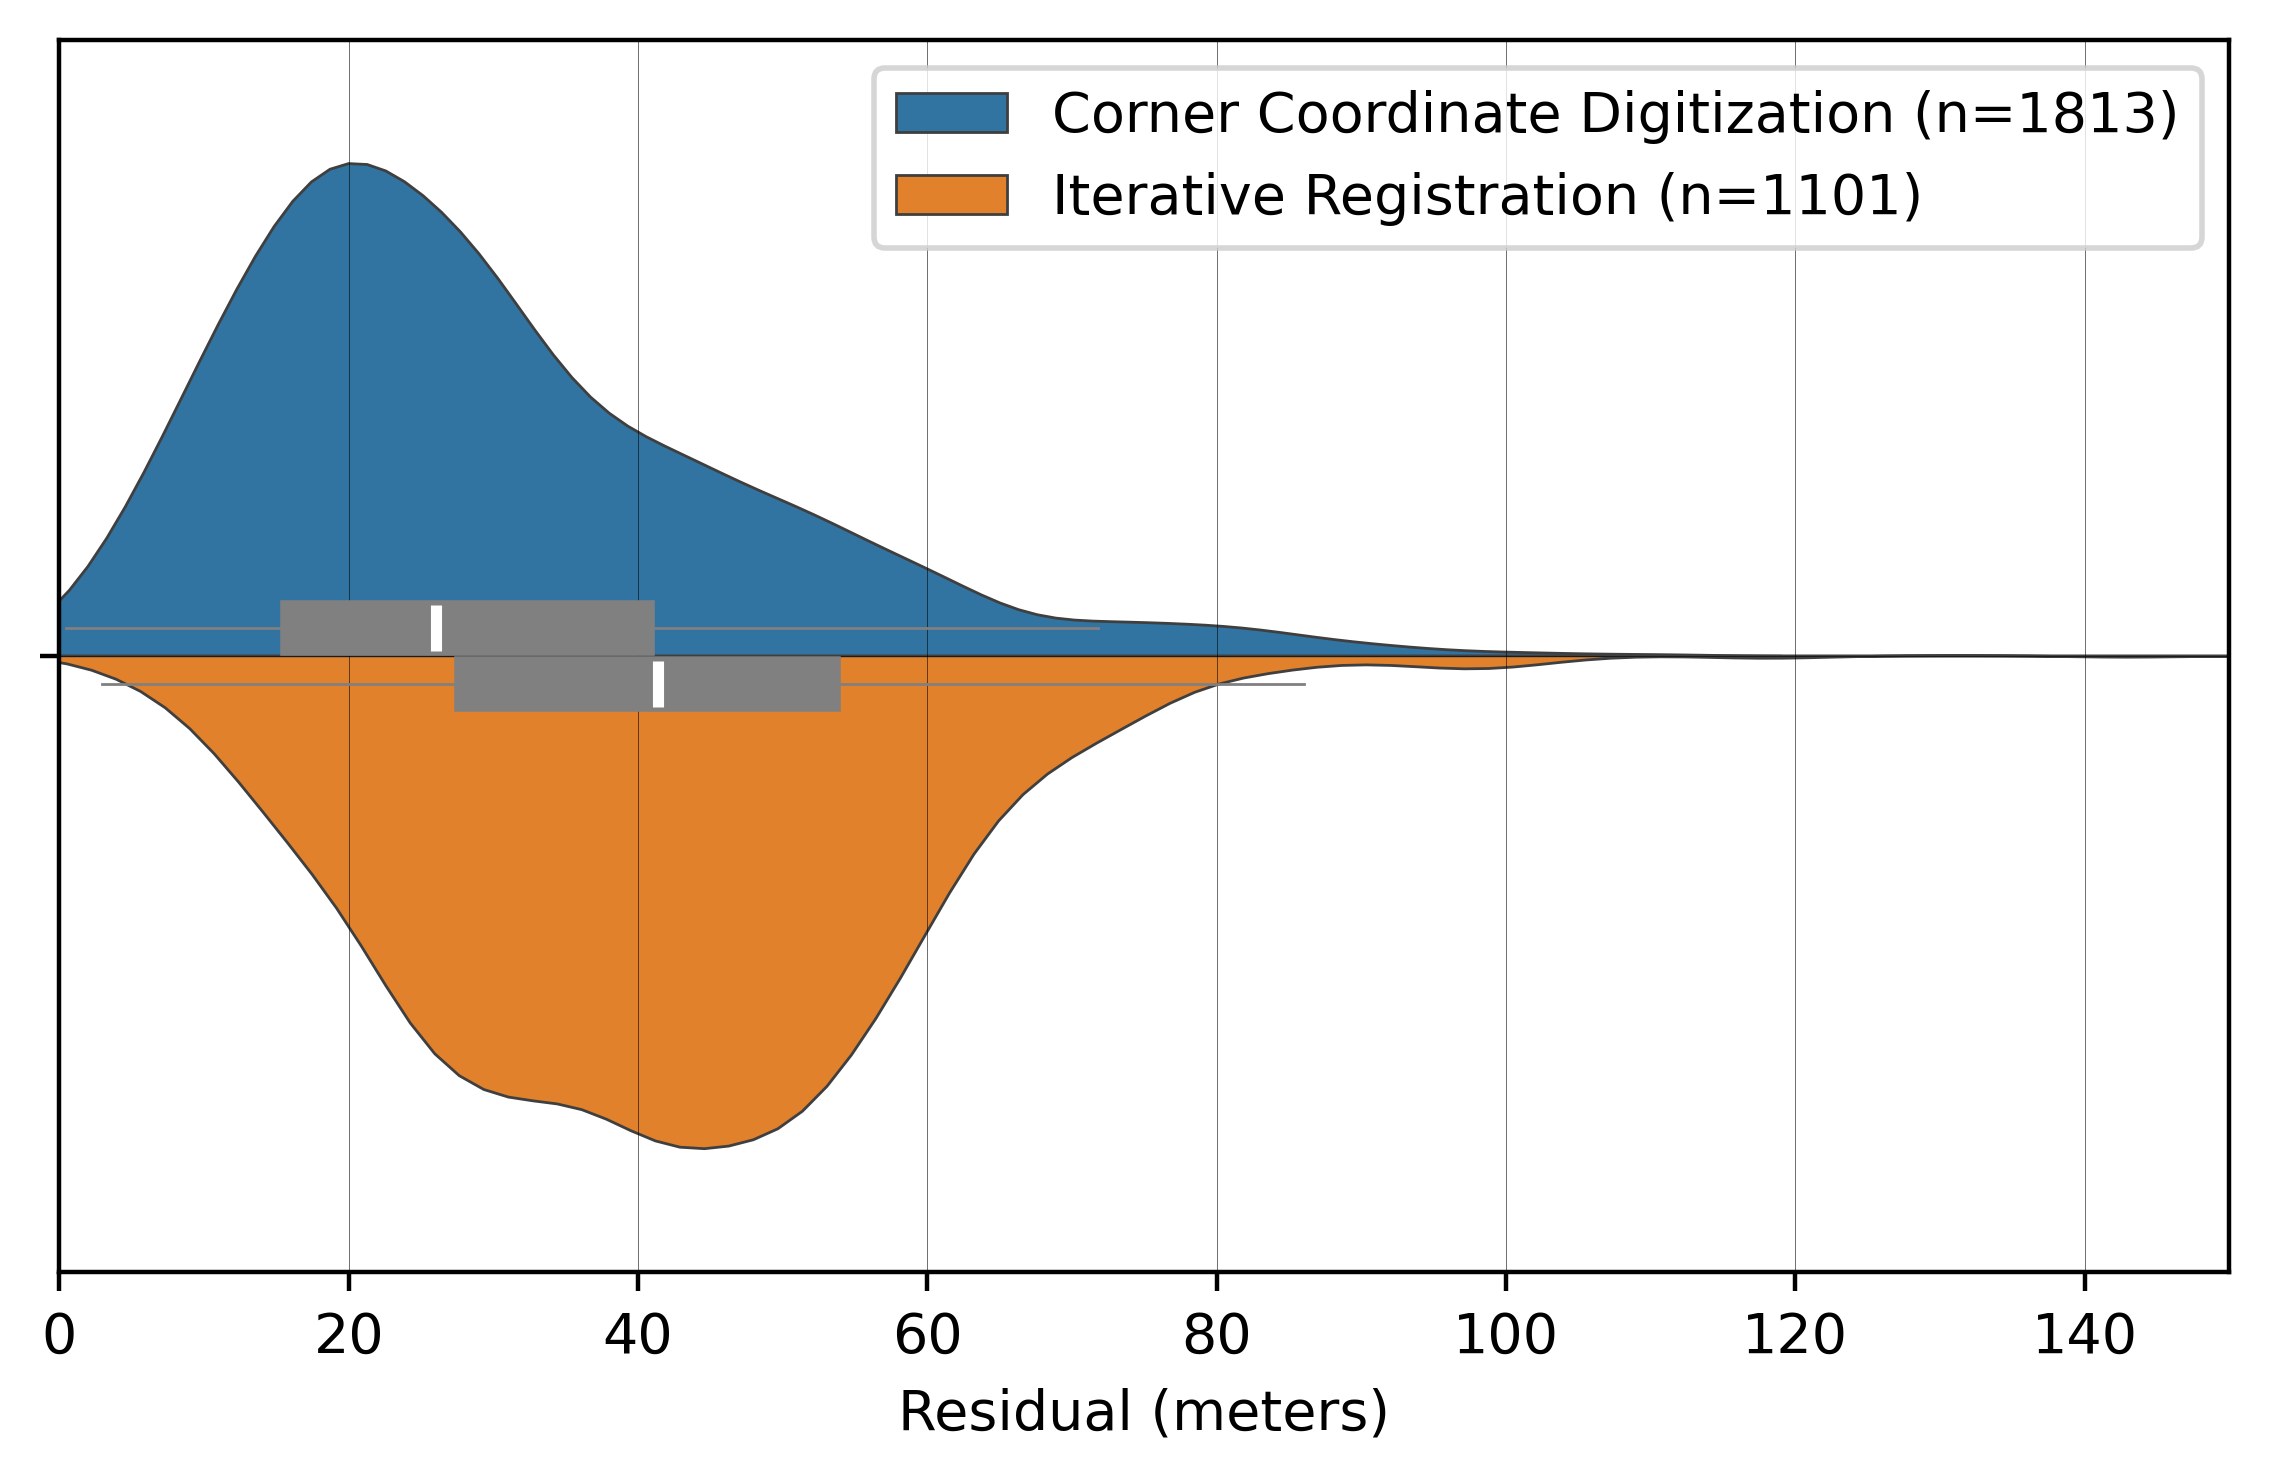

In [13]:
%matplotlib inline
fig, axs = plt.subplots(figsize=(7, 4), dpi=400)
# sns.boxplot(y='length', ax=axs, data=test[test['MATCH'] == 1])
# axs.set_yscale('log')
sns.violinplot(x='length', hue='method', split=True, ax=axs, data=test[test['MATCH'] == 1], inner='box', 
               linewidth=0.5, inner_kws=dict(box_width=10, whis_width=0.5, color="0.5"))

axs.set_xlabel("Residual (meters)")
axs.set_xlim((0, 150))

# new_labels = [f'Iterative Registration', 'Corner Coordinate Digitization']  # however many hue categories you have
# handles, labels = axs.get_legend_handles_labels()
# axs.legend(handles=handles, labels=new_labels, title="", loc="upper right")

# Get counts per method
filtered = test[test['MATCH'] == 1]
method_counts = filtered['method'].value_counts()

# Define new_labels dynamically
label_mapping = {
    'CornerCoordinate': 'Corner Coordinate Digitization',
    'Registration': 'Iterative Registration',
}
new_labels = [f"{label_mapping[m]} (n={method_counts[m]})" for m in method_counts.index]
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles=handles, labels=new_labels, title="", loc="upper right")


axs.grid(color='black', linewidth=0.1)

In [14]:
filtered['length'].median()

35.42522945082784

In [15]:
filtered.shape[0] / test.shape[0]

0.651318730442557

In [16]:
test.shape[0]

4474

In [17]:
from scipy.stats import ttest_ind

group0 = filtered[filtered['method'] == 'CornerCoordinate']['length']
group1 = filtered[filtered['method'] == 'Registration']['length']

print(group0.median())
print(group1.median())

# Perform Welch's two-sided t-test (independent variances)
t_stat, p_val = ttest_ind(group0, group1, equal_var=False)

print(f'T-statistic: {t_stat:.4f}')
print(f'P-value: {p_val:.4e}')

41.39190215994629
26.03137493361806
T-statistic: 17.7314
P-value: 7.0293e-66


In [18]:
current_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\checkpoint_112024_nontiled_1.pth"

In [19]:
checkpoint = torch.load(current_dir)

In [20]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'iou_lists', 'epoch_losses', 'lr_list'])

In [21]:
iou_train = np.stack(checkpoint['iou_lists']['train'])
iou_val = np.stack(checkpoint['iou_lists']['test'])

In [22]:
loss_train = np.stack(checkpoint['epoch_losses']['train'])
loss_val = np.stack(checkpoint['epoch_losses']['test'])

lr = np.stack(checkpoint['lr_list'])

In [32]:
print(np.max(curr_arry[:,1]))

0.7581489


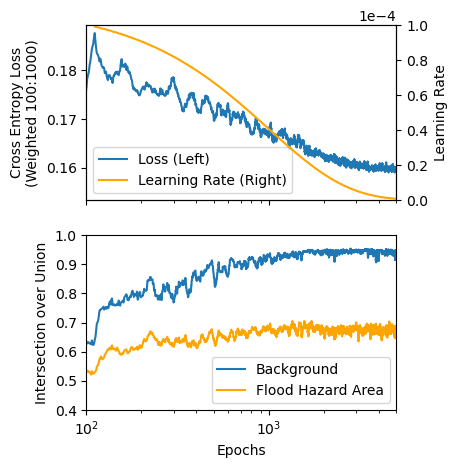

In [23]:
fig, axs = plt.subplots(2, figsize=(4, 5), sharex=True)

moving_window = 25

# axs[0].plot(checkpoint['iou_lists']['train'])

axs[0].plot(np.convolve(loss_train, np.ones(moving_window)/moving_window, mode='valid'), label='Loss (Left)')
par = axs[0].twinx()
par.ticklabel_format(axis='y', style='sci',  useOffset=False, scilimits=(0, 0))
par.plot(np.convolve(lr, np.ones(moving_window)/moving_window, mode='valid'), label='Learning Rate (Right)', color='orange')
par.set_ylim((0, 1e-4))

curr_arry = np.stack(checkpoint['iou_lists']['test'])

axs[1].plot(np.convolve(curr_arry[:,0], np.ones(moving_window)/moving_window, mode='valid'), label='Background')
axs[1].plot(np.convolve(curr_arry[:,1], np.ones(moving_window)/moving_window, mode='valid'), label='Flood Hazard Area', color='orange')

axs[1].set_xscale('log')
axs[1].set_xlim((100, 5000))
axs[1].set_ylim((0.4, 1))

axs[0].set_ylabel('Cross Entropy Loss\n(Weighted 100:1000)')
par.set_ylabel('Learning Rate')

axs[1].set_ylabel('Intersection over Union')
axs[1].set_xlabel('Epochs')

# Legend fix: merge handles from both axs[0] and par
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = par.get_legend_handles_labels()
axs[0].legend(handles0 + handles1, labels0 + labels1, loc='lower left')  # <- combined legend

# Second plot legend
axs[1].legend(loc='best')

In [24]:
model = TPNN(num_classes=2, inputsize=1, verbose_level=5)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
curr_image = r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\FLNN\48201C0315J.tif"

image = Image.open(curr_image).convert('L')
image = cv2.resize(np.array(image).astype(np.uint8), (1536, 1536), interpolation= cv2.INTER_AREA)            
image = Image.fromarray(np.array(image).astype(np.uint8))

tensor = transforms.Compose([transforms.ToTensor()])
input = tensor(image).unsqueeze(0)
out = model(input)

torch.Size([1, 64, 384, 384])
torch.Size([1, 64, 384, 384])
torch.Size([1, 128, 192, 192])
torch.Size([1, 256, 96, 96])
torch.Size([1, 512, 48, 48])
(torch.Size([1, 256, 96, 96]), torch.Size([1, 256, 96, 96]))
(torch.Size([1, 128, 192, 192]), torch.Size([1, 128, 192, 192]))
(torch.Size([1, 64, 384, 384]), torch.Size([1, 64, 384, 384]))
(torch.Size([1, 64, 1536, 1536]), torch.Size([1, 64, 384, 384]))


In [26]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

23541693

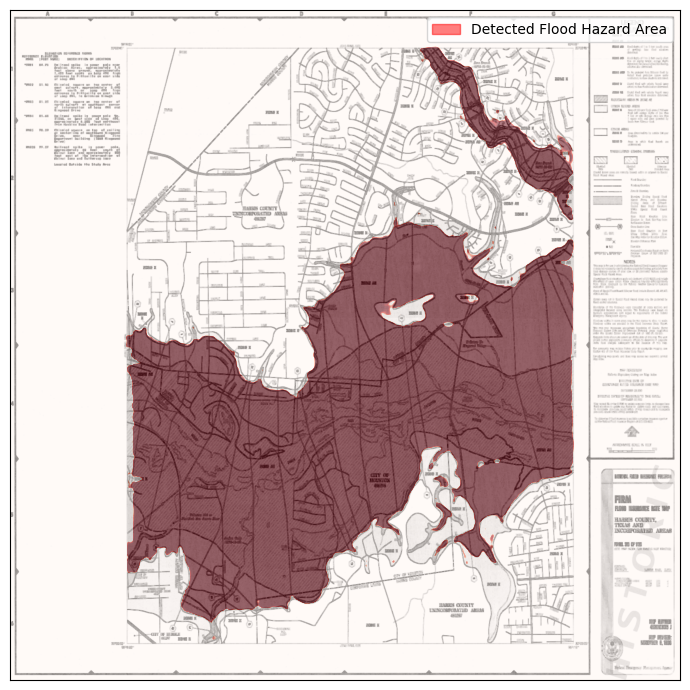

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7, 7),)

image_curr = cv2.erode(np.asarray(image),np.ones((3, 3), np.uint8))
# Show base image
ax.imshow(image_curr, cmap="Greys_r")

# Overlay the jurisdictional boundaries with transparency
ax.imshow(out[0, 1, :, :].detach().numpy(), vmin=0.5, vmax=1, cmap='Reds', alpha=0.5)

# Title and clean axes
ax.set_xticks([])
ax.set_yticks([])

# Legend
red_patch = mpatches.Patch(color='red', label='Detected Flood Hazard Area', alpha=0.5)
ax.legend(handles=[red_patch], loc='upper right')

plt.tight_layout()
plt.show()

In [28]:
model.verbose_level=5
out = model(input)

torch.Size([1, 64, 384, 384])
torch.Size([1, 64, 384, 384])
torch.Size([1, 128, 192, 192])
torch.Size([1, 256, 96, 96])
torch.Size([1, 512, 48, 48])
(torch.Size([1, 256, 96, 96]), torch.Size([1, 256, 96, 96]))
(torch.Size([1, 128, 192, 192]), torch.Size([1, 128, 192, 192]))
(torch.Size([1, 64, 384, 384]), torch.Size([1, 64, 384, 384]))
(torch.Size([1, 64, 1536, 1536]), torch.Size([1, 64, 384, 384]))


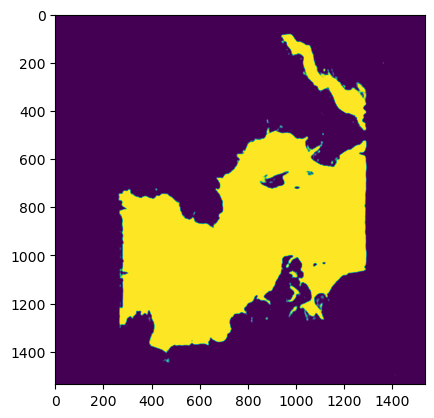

In [29]:
plt.imshow(out[0, 1, :, :].detach().numpy())

In [30]:
import subprocess
import geopandas as gpd

In [31]:
error
def clip_with_ogr2ogr(input_path, output_path, aoi_path):
    """
    Clips a spatial file to an AOI using ogr2ogr (GDAL).
    
    Args:
        input_path (str): Path to original big spatial file.
        output_path (str): Path where the clipped file will be saved.
        aoi_path (str): Path to the Area of Interest (polygon) file.
    """
    command = [
        "ogr2ogr",
        "-clipsrc", aoi_path,
        output_path,
        input_path
    ]
    subprocess.run(command, check=True)

    return gpd.read_file(output_path)

input = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_LineIntersections_strict.gpkg"
centroids = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg"
dissolved = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\scratch\DissolvedTexas.gpkg"

out_path = r"D:\CaseStudies\Reference_Validation\\"
aoi_path = r"D:\CaseStudies\Reference_Validation\HarrisBoundary_3857.gpkg"

print(1)
input_gdf = clip_with_ogr2ogr(input, out_path + "clipped_input.gpkg", aoi_path)
print(2)
dissolved_polygon = clip_with_ogr2ogr(dissolved, out_path + "clipped_dissolved_polygons.gpkg", aoi_path)
print(3)
buffered_dissolved_centroids = clip_with_ogr2ogr(centroids, out_path + "clipped_centroids.gpkg", aoi_path)

NameError: name 'error' is not defined

In [ ]:
buffered_dissolved_centroids = gpd.GeoDataFrame(geometry=dissolved_polygon.centroid)

In [ ]:
# Ensure CRS matches
input_gdf = input_gdf.to_crs(dissolved_polygon.crs)
buffered_dissolved_centroids = buffered_dissolved_centroids.to_crs(dissolved_polygon.crs)

# Spatial join: assign each original point to the dissolved polygon
input_with_cluster = gpd.sjoin(input_gdf, dissolved_polygon, how="left", predicate="within")
input_with_cluster = input_with_cluster.dropna(subset=["index_right"])  # remove unmatched if any

# Re-attach centroids (cluster id = index of dissolved polygon)
buffered_dissolved_centroids["cluster_id"] = dissolved_polygon.index
input_with_cluster["cluster_id"] = input_with_cluster["index_right"].astype(int)

# Merge to get centroid for each original point
merged = input_with_cluster.merge(
    buffered_dissolved_centroids[["cluster_id", "geometry"]],
    on="cluster_id",
    suffixes=("_orig", "_centroid")
)

# Calculate displacement
merged["displacement_m"] = merged.apply(
    lambda row: row["geometry_orig"].distance(row["geometry_centroid"]),
    axis=1
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

10.449978993285297
26.081903665670435


(array([1.93318e+05, 3.02340e+04, 1.06240e+04, 5.14400e+03, 2.81600e+03,
        9.66000e+02, 3.94000e+02, 1.12000e+02, 4.60000e+01, 2.00000e+01]),
 array([1.07770723e-01, 1.50005266e+01, 2.98932826e+01, 4.47860385e+01,
        5.96787944e+01, 7.45715504e+01, 8.94643063e+01, 1.04357062e+02,
        1.19249818e+02, 1.34142574e+02, 1.49035330e+02]),
 <BarContainer object of 10 artists>)

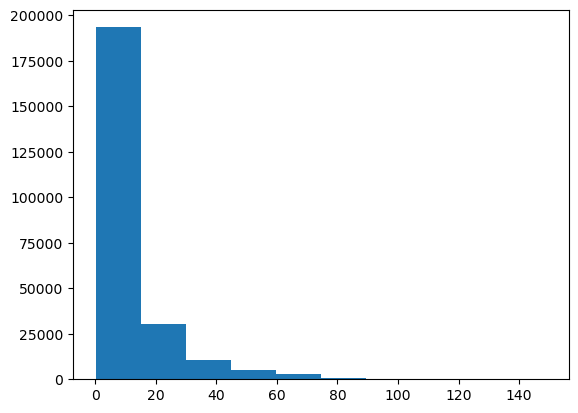

In [ ]:
print(merged[merged['displacement_m'] > 0.1]['displacement_m'].median())
print(np.nanpercentile(merged[merged['displacement_m'] > 0.1]['displacement_m'].to_numpy(), 90))
plt.hist(merged[merged['displacement_m'] > 0.1]['displacement_m'])